# Setup Model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from UtilityMethods import utils
import sys
import pickle
import time
import pulp as p
import math
from copy import copy
import pprint as pp
import itertools
from tqdm import tqdm

## Global variables

In [55]:
# Global variables

IS_VISIT_DEPENDENT = False # whether the above empirical estimates are visit-dependent or not
DATA = '../data/ACCORD_BGClass_v2.csv'

EPISODE_LENGTH = 20 # average number of visits per patient
CONSTRAINT = 15 # deviation * 20 visits 
C_b = 8  # constraint for baseline policy.
delta = 0.01 # bound

EPS = 0.01 # not used
M = 0 # not used

## State space and action space

In [3]:
# state space, actions available in each state are always the same

"""
# original fine-grained levels
state_features = ['sbp_discrete','hba1c_discrete','TC_discrete','hdl_discrete','BMI_discrete'] 
sbp_level = ['0', '1', '2', '3'] # possible values for sbp_discrete
hba1c_level = ['0', '1', '2', '3', '4', '5', '6', '7']
TC_level = ['0', '1', '2', '3']
hdl_level = ['0', '1', '2', '3']
BMI_level = ['0', '1', '2', '3']
"""

# here we merge levels
sbp_level = ['0', '1', '2'] # sbp_discrete, 0: 0, 1:1, 2+3: 2
hba1c_level = ['0', '1', '2'] # hba1c_discrete, 0+1: 0, 2+3: 1, 4+5+6+7: 2
TC_level = ['0', '1'] # TC_discrete, 0+1: 0, 2+3: 1
hdl_level = ['0', '1'] # hdl_discrete, 0+1: 0, 2+3: 1

sbp_discrete_code_dict = {'0': '0', '1': '1',
                          '2': '2', '3': '2',}

hba1c_discrete_code_dict = {'0': '0', '1': '0', 
                            '2': '1', '3': '1', 
                            '4': '2', '5': '2', 
                            '6': '2', '7': '2'}

TC_discrete_code_dict = {'0': '0', '1': '0',
                         '2': '1', '3': '1'}

hdl_discrete_code_dict = {'0': '0', '1': '0',
                          '2': '1', '3': '1'}

# 4 features, state space = 36
# state_features = ['sbp_discrete', 'hba1c_discrete', 'TC_discrete', 'hdl_discrete'] 
# combinations = itertools.product(sbp_level, hba1c_level, TC_level, hdl_level)

# 3 features, state space = 18
# state_features = ['sbp_discrete', 'hba1c_discrete', 'TC_discrete'] 
# combinations = itertools.product(sbp_level, hba1c_level, TC_level)

# 2 features, state space = 9
# combinations = itertools.product(sbp_level, hba1c_level)
# state_features = ['sbp_discrete', 'hba1c_discrete'] 

# 1 feature, srtate space = 3
combinations = itertools.product(hba1c_level)
state_features = ['hba1c_discrete'] 

states = [''.join(i) for i in combinations]
print('len(states) =', len(states))
print(states[:5])

N_STATES = len(states) 
state_code_to_index = {code: i for i, code in enumerate(states)}
# print the first 5 state_code_to_index
for i in range(3):
    print(states[i], state_code_to_index[states[i]])
print()



# action space, 000000000 means bgclass_none, 111111111 means all bgmed class are precribed
# we donot include 'bgclass_none' as a action, because 000000000 means bgclass_none
action_features = ['Bingu', 'Thiaz', 'Sulfon', 'Meglit'] # pick the top 4 most frequently prescribed bgmed class 

combinations = list(itertools.product('01', repeat=len(action_features)))
actions = [''.join(i) for i in combinations]
print('len(actions) =', len(actions))
N_ACTIONS = len(actions) # number of actions = 512
action_code_to_index = {code: i for i, code in enumerate(actions)}
# print the first 5 action_code_to_index
for i in range(5):
    print(actions[i], action_code_to_index[actions[i]])

# build the action space for each state, assign the same action space to all states
ACTIONS_PER_STATE = {}
for s in range(N_STATES):
    ACTIONS_PER_STATE[s] = [i for i in range(N_ACTIONS)] # this is the action code index
print('Actions for State 0:', ACTIONS_PER_STATE[0])

len(states) = 3
['0', '1', '2']
0 0
1 1
2 2

len(actions) = 16
0000 0
0001 1
0010 2
0011 3
0100 4
Actions for State 0: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


## Calculate empirical estimates of P, R, C

In [4]:
df = pd.read_csv(DATA)

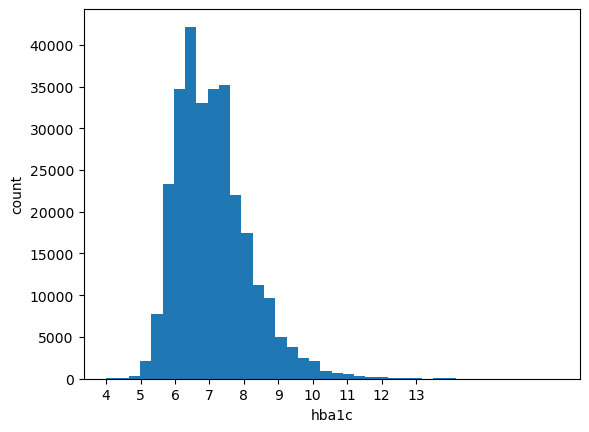

In [5]:
# plot the distribution of the 'hba1c' feature, set x-axis interval to be 1
plt.hist(df['hba1c'], bins=40)
plt.xticks(np.arange(4, 14, 1))
plt.xlabel('hba1c')
plt.ylabel('count')
plt.show()

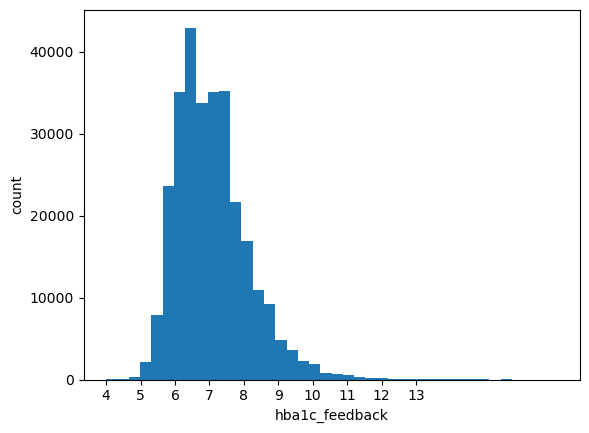

In [21]:
# plot the distribution of the 'hba1c_feedback' feature, set x-axis interval to be 1
plt.hist(df['hba1c_feedback'], bins=40)
plt.xticks(np.arange(4, 14, 1))
plt.xlabel('hba1c_feedback')
plt.ylabel('count')
plt.show()

In [6]:
# add the state and action code columns
action_code = []
state_code = []
hba1c_discrete_merged = []
for i in range(len(df)):
    row = df.iloc[i]
    s_code = ''
    a_code = ''
    for state_fea in state_features:
        code = str(row[state_fea])

        # merge 3 with 2 for sbp_discrete and TC_discrete
        if state_fea == 'sbp_discrete':
            code = sbp_discrete_code_dict[code]            
        elif state_fea == 'hba1c_discrete':
            code = hba1c_discrete_code_dict[code]
            hba1c_discrete_merged.append(code)
        elif state_fea == 'TC_discrete':
            code = TC_discrete_code_dict[code]
        elif state_fea == 'hdl_discrete':
            code = hdl_discrete_code_dict[code]
        else:
            raise ValueError('state_fea not recognized')
            exit(1)       
        
        s_code += code
    
    for action_fea in action_features:
        a_code += str(row[action_fea])
    
    action_code.append(a_code)
    state_code.append(s_code)

assert len(hba1c_discrete_merged) == len(df)

df['hba1c_discrete_merged'] = hba1c_discrete_merged
df['action_code'] = action_code
df['state_code'] = state_code
print('Finished adding action_code and state_code columns')

DATA_MERGED = DATA[:-4] + '_merged.csv'
# write the merged data to file
df.to_csv(DATA_MERGED, index=False)

Finished adding action_code and state_code columns


In [7]:
#------------- calculate the empirical estimate of P, R, C based on entire dataset ----------------
        
count_s_a = {} # count the number of times state s and action a appear in the dataset, sparse format
count_s_a_d = {} # count the number of times state s, action a, and next state s' appear in the dataset
sum_r_s_a = {} # sum of the reward of state s and action a
sum_c_s_a = {} # sum of the cost of state s and action a, this is the absolute value of SBP feedback
visit_number = [] # number of visits for each patient

# loop through each patient in the dataset
for i in tqdm(range(100001, 110252)):
    df_patient = df[df['MaskID'] == i]

    if len(df_patient) > 0:
        visit_number.append(len(df_patient))

    # loop through each visit of the patient
    for j in range(len(df_patient)-1): # loop before last visit
        row = df_patient.iloc[j]
        s_code = row['state_code']
        a_code = row['action_code']
        ns_code = df_patient.iloc[j+1]['state_code']

        # convert from code to index
        s = state_code_to_index[s_code]
        a = action_code_to_index[a_code]
        s_ = state_code_to_index[ns_code]

        r = df_patient.iloc[j]['CVDRisk_feedback']
        hba1c_fb = df_patient.iloc[j]['hba1c_feedback']
        c = hba1c_fb

        if (s, a) not in count_s_a:
            count_s_a[(s, a)] = 1
            sum_r_s_a[(s, a)] = r 
            sum_c_s_a[(s, a)] = c
        else:
            count_s_a[(s, a)] += 1
            sum_r_s_a[(s, a)] += r
            sum_c_s_a[(s, a)] += c

        if (s, a, s_) not in count_s_a_d:
            count_s_a_d[(s, a, s_)] = 1
        else:
            count_s_a_d[(s, a, s_)] += 1

print('len(visit_number) =', len(visit_number))
print('averge visit_number =', sum(visit_number)/len(visit_number))

print('len(count_s_a) =', len(count_s_a))
print('len(count_s_a_d) =', len(count_s_a_d))
print('Finished counting by looping through the dataset')

100%|██████████| 10251/10251 [02:19<00:00, 73.27it/s]

len(visit_number) = 8075
averge visit_number = 35.97114551083591
len(count_s_a) = 48
len(count_s_a_d) = 144
Finished counting by looping through the dataset


In [8]:
# calculate the sparsity of state-action pairs
print('Total possible state-action pairs =', N_STATES * N_ACTIONS)
print('Seen state-action pairs =', len(count_s_a))
print('Unseen state-action pairs =', N_STATES * N_ACTIONS - len(count_s_a))
print('Sparsity of state-action pairs =', 1 - len(count_s_a)/(N_STATES * N_ACTIONS))

Total possible state-action pairs = 48
Seen state-action pairs = 48
Unseen state-action pairs = 0
Sparsity of state-action pairs = 0.0


In [9]:
# calculate the empirical estimate of P, R, C using counts

# initialize R, C, P, NOT using sparse matrix format
R = {} # N_STATES * N_ACTIONS, dictionary of reward matrices, this is the CVDRisk empirical estimate based on entire dataset
C = {} # N_STATES * N_ACTIONS, dictionary of cost matrices, this is SBP empirical estimate based on entire dataset
P = {} # N_STATES * N_ACTIONS * N_STATES, dictionary of transition probability matrices, based on the entire dataset

for s in range(N_STATES):
    l = len(actions)
    R[s] = np.zeros(l)
    C[s] = np.zeros(l)
    P[s] = {}    
    for a in range(N_ACTIONS):
        P[s][a] = np.zeros(N_STATES)
        
print('Finished initializing R, C, P')

for (s,a) in count_s_a: # only calculate for the states and actions that appearedin the dataset, for efficiency

    R[s][a] = sum_r_s_a[(s, a)]/max(count_s_a[(s, a)],1)
    C[s][a] = sum_c_s_a[(s, a)]/max(count_s_a[(s, a)],1)

for (s, a, s_) in count_s_a_d:
    P[s][a][s_] = count_s_a_d[(s, a, s_)]/max(count_s_a[(s, a)],1)

print('Finished calculating the empirical estimate of P, R, C')

#------------- check the sparsity of P, R, C
print('\nDetails of P, R, C:')
print('P: {:.6f}% are non-zeros'.format(len(count_s_a_d)*100/(N_STATES*N_ACTIONS*N_STATES)))
print('R: {:.6f}% are non-zeros'.format(len(sum_r_s_a)*100/(N_STATES*N_ACTIONS)))
print('C: {:.6f}% are non-zeros'.format(len(sum_c_s_a)*100/(N_STATES*N_ACTIONS)))

# print sample values of P, R, C
print('\nSample values of P, R, C:')
print('P[0][0][0] =', P[0][0][0])
print('R[0][0] =', R[0][0])
print('C[0][0] =', C[0][0])

# print the min, max, mean, median of R and C, R and C are dictionaries of numpy arrays
print('\nStatistics of R and C:')
print('R: min = {:.6f}, max = {:.6f}, mean = {:.6f}, median = {:.6f}, std = {:.6f}'.format(np.min(list(R.values())), np.max(list(R.values())), np.mean(list(R.values())), np.median(list(R.values())), np.std(list(R.values()))))
print('C: min = {:.6f}, max = {:.6f}, mean = {:.6f}, median = {:.6f}, std = {:.6f}'.format(np.min(list(C.values())), np.max(list(C.values())), np.mean(list(C.values())), np.median(list(C.values())), np.std(list(C.values()))))
#print('C: min = {:.6f}, max = {:.6f}, mean = {:.6f}, median = {:.6f}'.format(np.min(list(C.values())), np.max(list(C.values())), np.mean(list(C.values())), np.median(list(C.values()))))

Finished initializing R, C, P
Finished calculating the empirical estimate of P, R, C

Details of P, R, C:
P: 100.000000% are non-zeros
R: 100.000000% are non-zeros
C: 100.000000% are non-zeros

Sample values of P, R, C:
P[0][0][0] = 0.9334208552138035
R[0][0] = 0.2349756180925602
C[0][0] = 6.073943485871396

Statistics of R and C:
R: min = 0.211539, max = 0.298925, mean = 0.247541, median = 0.236958, std = 0.024006
C: min = 6.020012, max = 8.367002, mean = 7.079614, median = 6.969850, std = 0.861756


In [10]:
# # normalize R and C to the range [0, 1]

# # !!! we should not normalize C (sbp), becasue we need to satisfy the constraint that SBP in range 110-125
# # maybe no need to normalize R

# max_R = max([R[s][a] for s in R for a in range(N_ACTIONS)])
# min_R = min([R[s][a] for s in R for a in range(N_ACTIONS)])
# max_C = max([C[s][a] for s in C for a in range(N_ACTIONS)])

# print('max_R =', max_R)
# print('max_C =', max_C)

# for s in R:
#     for a in range(N_ACTIONS):
#         R[s][a] = (R[s][a]-min_R)/(max_R)
# #         # C[s][a] = (C[s][a])/(max_C)


# #---------- assign average reward and cost to unseen state-action pairs

# # get the average of R and C
# R_sum = 0
# R_ct = 0
# C_sum = 0
# C_ct = 0
# for (s,a) in count_s_a:
#     R_sum += R[s][a]
#     R_ct += 1
#     C_sum += C[s][a]
#     C_ct += 1

# print('R_sum =', R_sum, 'R_ct =', R_ct)
# R_avg = R_sum/R_ct
# print('R_avg =', R_avg)

# print('C_sum =', C_sum, 'C_ct =', C_ct)
# C_avg = C_sum/C_ct
# print('C_avg =', C_avg)

# # assign the average to unseen state-action pairs
# for s in range(N_STATES):
#     for a in range(N_ACTIONS):
#         if (s,a) not in count_s_a:
#             R[s][a] = R_avg
#             C[s][a] = C_avg

#print('\nStatistics of R:')
#print('R: min = {:.6f}, max = {:.6f}, mean = {:.6f}, median = {:.6f}, std = {:.6f}'.format(np.min(list(R.values())), np.max(list(R.values())), np.mean(list(R.values())), np.median(list(R.values())), np.std(list(R.values()))))


In [11]:
# # assign uniform probability to unseen state-action-state triples
# for s in range(N_STATES):
#     for a in range(N_ACTIONS):
#         if (s,a) not in count_s_a:
#             for s_ in range(N_STATES):
#                 P[s][a][s_] = 1/N_STATES

# # check the sparsity of P

# def check_sparsity_P(P):
#     count_nonzero_P = 0
#     for s in range(N_STATES):
#         for a in range(N_ACTIONS):
#             for s_ in range(N_STATES):
#                 if P[s][a][s_] != 0:
#                     count_nonzero_P += 1
#     print("Percentage of non-zero elements in P:", count_nonzero_P*100/(N_STATES*N_ACTIONS*N_STATES))

# check_sparsity_P(P)

In [12]:
# # assign uniform probability to all state-action-state triples
# for s in range(N_STATES):
#     for a in range(N_ACTIONS):
#         for s_ in range(N_STATES):
#             P[s][a][s_] = 1/(N_STATES)

# check_sparsity_P(P)

## Check Init states

In [81]:
def check_frequency(df, col_name):
    df = df[col_name]
    df = df.value_counts()
    print(df)
    print()

    # return the first index in the series
    return df.index[0]
    
# get the rows when the visit=='BLR' in df
df_blr = df[df['Visit']=='BLR']
INIT_STATES_LIST = df_blr['state_code'].unique() # we will sample uniformly from this list
print('len(INIT_STATES_LIST) =', len(INIT_STATES_LIST))

print('df_blr.shape =', df_blr.shape)
most_freq_blr_state = check_frequency(df_blr, 'state_code')
print('most_freq_blr_state =', most_freq_blr_state)
INIT_STATE_INDEX = state_code_to_index[most_freq_blr_state]
print('INIT_STATE_INDEX =', INIT_STATE_INDEX)

len(INIT_STATES_LIST) = 3
df_blr.shape = (8075, 67)
2    6414
1    1564
0      97
Name: state_code, dtype: int64

most_freq_blr_state = 2
INIT_STATE_INDEX = 2
df_blr[df_blr["state_code"]==0]["MaskID"] = [100165, 100294, 100345, 100420, 100445, 100520, 100692, 100813, 101106, 101209, 101281, 101314, 101367, 101512, 101698, 101840, 101844, 101996, 102001, 102276, 102323, 102350, 102477, 102478, 102545, 102798, 102801, 102857, 102870, 102995, 103031, 103128, 103155, 103303, 103521, 103551, 103687, 103706, 103806, 103817, 104043, 104052, 104120, 104131, 104324, 104337, 104338, 104339, 104476, 104517, 104749, 104868, 104977, 105106, 105183, 105311, 105386, 105428, 105451, 105481, 105501, 105730, 105770, 105931, 106045, 106340, 106721, 106849, 107005, 107081, 107259, 107433, 107553, 107774, 107836, 107898, 108065, 108176, 108299, 108502, 108507, 108568, 108586, 108726, 108807, 108913, 109114, 109239, 109314, 109686, 109729, 109792, 110006, 110123, 110147, 110192, 110210]


In [ ]:
# print the patient MASKID in df_blr with state_code = 0
patient = list(df_blr[df_blr['state_code']=='0']['MaskID'])
print('patient =', patient)
print('len(patient) =', len(patient))

## Compute solution.pkl and baseline.pkl files

### Save the model settings

In [59]:
# dump the model settings and parameters to a pickle file
print('C_b =', C_b)
with open('output/model.pkl', 'wb') as f:
    pickle.dump([P, R, C, INIT_STATE_INDEX, INIT_STATES_LIST, state_code_to_index,
                CONSTRAINT, C_b, N_STATES, N_ACTIONS, ACTIONS_PER_STATE, EPISODE_LENGTH, delta], f)

C_b = 8


### Calculate the optimal policy

In [60]:
import importlib
import sys
importlib.reload(sys.modules['UtilityMethods'])
from UtilityMethods import utils

opt_policy_con_list = []
opt_value_LP_con_list = []
opt_cost_LP_con_list = []
opt_q_con_list = []

print('Optimal policy:')
for state_idx in range(N_STATES):
    print('\nstate_idx =', state_idx)
    INIT_STATE_INDEX = state_idx
    util_methods_1 = utils(EPS, delta, M, P, R, C, INIT_STATE_INDEX, EPISODE_LENGTH, N_STATES, N_ACTIONS, ACTIONS_PER_STATE, CONSTRAINT, C_b)

    # constrained MDP, solve the optimal policy using LP
    opt_policy_con, opt_value_LP_con, opt_cost_LP_con, opt_q_con = util_methods_1.compute_opt_LP_Constrained(0)

    # unconstrained = standard MDP, not used in DOPE
    # opt_policy_uncon, opt_value_LP_uncon, opt_cost_LP_uncon, opt_q_uncon = util_methods_1.compute_opt_LP_Unconstrained(0) 

    opt_policy_con_list.append(opt_policy_con)
    opt_value_LP_con_list.append(opt_value_LP_con)
    opt_cost_LP_con_list.append(opt_cost_LP_con)
    opt_q_con_list.append(opt_q_con)

    print("opt_value_LP_con[INIT_STATE_INDEX, 0] =",opt_value_LP_con[INIT_STATE_INDEX, 0])
    print("opt_cost_LP_con[INIT_STATE_INDEX, 0] =",opt_cost_LP_con[INIT_STATE_INDEX, 0])
    

with open('output/solution.pkl', 'wb') as f:
    pickle.dump([opt_policy_con_list, opt_value_LP_con_list, opt_cost_LP_con_list, opt_q_con_list], f)

Optimal policy:

state_idx = 0

Computing optimal policy with constrained LP solver ...
Optimal
printing best value constrained: 4.340695148008305

value from the conLPsolver:
value of policy = 4.340695148008305
cost of policy = 10.91411178575703
opt_value_LP_con[INIT_STATE_INDEX, 0] = 4.340695140498941
opt_cost_LP_con[INIT_STATE_INDEX, 0] = 10.914111773614167

state_idx = 1

Computing optimal policy with constrained LP solver ...
Optimal
printing best value constrained: 4.398611190432709

value from the conLPsolver:
value of policy = 4.398611190432709
cost of policy = 5.3220817100459294
opt_value_LP_con[INIT_STATE_INDEX, 0] = 4.398611187708296
opt_cost_LP_con[INIT_STATE_INDEX, 0] = 5.322081693096788

state_idx = 2

Computing optimal policy with constrained LP solver ...
Optimal
printing best value constrained: 4.34908533371961

value from the conLPsolver:
value of policy = 4.34908533371961
cost of policy = 5.165475365375958
opt_value_LP_con[INIT_STATE_INDEX, 0] = 4.3490853370801235
op

### Calculate the baseline policy

In [61]:
# baseline policy
print("Baseline policy:")

policy_b_list = []
value_b_list = []
cost_b_list = []
q_b_list = []

for state_idx in range(N_STATES):
    print('\nstate_idx =', state_idx)
    INIT_STATE_INDEX = state_idx

    util_methods_1 = utils(EPS, delta, M, P, R, C, INIT_STATE_INDEX, EPISODE_LENGTH, N_STATES, N_ACTIONS, ACTIONS_PER_STATE, C_b, C_b)
    policy_b, value_b, cost_b, q_b = util_methods_1.compute_opt_LP_Constrained(0)

    policy_b_list.append(policy_b)
    value_b_list.append(value_b)
    cost_b_list.append(cost_b)
    q_b_list.append(q_b)

    print("value_b[INIT_STATE_INDEX, 0] =",value_b[INIT_STATE_INDEX, 0])
    print("cost_b[INIT_STATE_INDEX, 0] =",cost_b[INIT_STATE_INDEX, 0])

with open('output/base.pkl', 'wb') as f:
    pickle.dump([policy_b_list, value_b_list, cost_b_list, q_b_list], f)

Baseline policy:

state_idx = 0

Computing optimal policy with constrained LP solver ...
Optimal
printing best value constrained: 4.7011125362168125

value from the conLPsolver:
value of policy = 4.7011125362168125
cost of policy = 8.000000005703395
value_b[INIT_STATE_INDEX, 0] = 4.7011125361906005
cost_b[INIT_STATE_INDEX, 0] = 7.999999999918658

state_idx = 1

Computing optimal policy with constrained LP solver ...
Optimal
printing best value constrained: 4.398611190432709

value from the conLPsolver:
value of policy = 4.398611190432709
cost of policy = 5.3220817100459294
value_b[INIT_STATE_INDEX, 0] = 4.398611187708296
cost_b[INIT_STATE_INDEX, 0] = 5.322081693096788

state_idx = 2

Computing optimal policy with constrained LP solver ...
Optimal
printing best value constrained: 4.34908533371961

value from the conLPsolver:
value of policy = 4.34908533371961
cost of policy = 5.165475365375958
value_b[INIT_STATE_INDEX, 0] = 4.3490853370801235
cost_b[INIT_STATE_INDEX, 0] = 5.165475372598

In [46]:
print('INIT_STATE_INDEX =', INIT_STATE_INDEX)
print("opt_value_LP_con[INIT_STATE_INDEX, 0] =",opt_value_LP_con[INIT_STATE_INDEX, 0])
print("value_b[INIT_STATE_INDEX, 0] =",value_b[INIT_STATE_INDEX, 0])
print("opt_cost_LP_con[INIT_STATE_INDEX, 0] =",opt_cost_LP_con[INIT_STATE_INDEX, 0])
print("cost_b[INIT_STATE_INDEX, 0] =",cost_b[INIT_STATE_INDEX, 0])
print("cost_b[1, 0] =",cost_b[1, 0])
print("cost_b[0, 0] =",cost_b[0, 0])

INIT_STATE_INDEX = 2
opt_value_LP_con[INIT_STATE_INDEX, 0] = 4.3490853370801235
value_b[INIT_STATE_INDEX, 0] = 4.359725921177753
opt_cost_LP_con[INIT_STATE_INDEX, 0] = 5.165475372598975
cost_b[INIT_STATE_INDEX, 0] = 5.000000000077998
cost_b[1, 0] = 5.105092513610601
cost_b[0, 0] = 10.85980197560928


### Decode calculated optimal and baseline policy

In [18]:
# decode the opt_policy_con [s, h, a]

def action_code_to_med_action(action_code):
    med_action = []
    for i in range(len(action_code)):
        if action_code[i] == '0':
            continue
        elif action_code[i] == '1':
            med_action.append(action_features[i])
    
    if len(med_action) == 0:
        return 'BGClass_none'
    else:
        return '+'.join(med_action)

for s in range(N_STATES):
    for h in range(EPISODE_LENGTH):
        for a in range(N_ACTIONS):
            if opt_policy_con[s, h, a] != 0:
                action_code = actions[a]
                med_action = action_code_to_med_action(action_code)
                # print('opt_policy_con[', s, ',', h, ',', a, '] =', opt_policy_con[s, h, a], ', action_code =', actions[a])
                print('state {}, timestep {}, action_code {}, prob {}: {}'.format(s, h, action_code, opt_policy_con[s, h, a], med_action))


state 0, timestep 0, action_code 0000, prob 0.0625: BGClass_none
state 0, timestep 0, action_code 0001, prob 0.0625: Meglit
state 0, timestep 0, action_code 0010, prob 0.0625: Sulfon
state 0, timestep 0, action_code 0011, prob 0.0625: Sulfon+Meglit
state 0, timestep 0, action_code 0100, prob 0.0625: Thiaz
state 0, timestep 0, action_code 0101, prob 0.0625: Thiaz+Meglit
state 0, timestep 0, action_code 0110, prob 0.0625: Thiaz+Sulfon
state 0, timestep 0, action_code 0111, prob 0.0625: Thiaz+Sulfon+Meglit
state 0, timestep 0, action_code 1000, prob 0.0625: Bingu
state 0, timestep 0, action_code 1001, prob 0.0625: Bingu+Meglit
state 0, timestep 0, action_code 1010, prob 0.0625: Bingu+Sulfon
state 0, timestep 0, action_code 1011, prob 0.0625: Bingu+Sulfon+Meglit
state 0, timestep 0, action_code 1100, prob 0.0625: Bingu+Thiaz
state 0, timestep 0, action_code 1101, prob 0.0625: Bingu+Thiaz+Meglit
state 0, timestep 0, action_code 1110, prob 0.0625: Bingu+Thiaz+Sulfon
state 0, timestep 0, acti

In [19]:
# decode the policy_b [s, h, a]
for s in range(N_STATES):
    for h in range(EPISODE_LENGTH):
        for a in range(N_ACTIONS):
            if policy_b[s, h, a] != 0:
                # print('policy_b[', s, ',', h, ',', a, '] =', policy_b[s, h, a], ', action_code =', actions[a])
                action_code = actions[a]
                med_action = action_code_to_med_action(action_code)
                # print('opt_policy_con[', s, ',', h, ',', a, '] =', opt_policy_con[s, h, a], ', action_code =', actions[a])
                print('state {}, timestep {}, action_code {}, prob {}: {}'.format(s, h, action_code, opt_policy_con[s, h, a], med_action))                

state 0, timestep 0, action_code 0000, prob 0.0625: BGClass_none
state 0, timestep 0, action_code 0001, prob 0.0625: Meglit
state 0, timestep 0, action_code 0010, prob 0.0625: Sulfon
state 0, timestep 0, action_code 0011, prob 0.0625: Sulfon+Meglit
state 0, timestep 0, action_code 0100, prob 0.0625: Thiaz
state 0, timestep 0, action_code 0101, prob 0.0625: Thiaz+Meglit
state 0, timestep 0, action_code 0110, prob 0.0625: Thiaz+Sulfon
state 0, timestep 0, action_code 0111, prob 0.0625: Thiaz+Sulfon+Meglit
state 0, timestep 0, action_code 1000, prob 0.0625: Bingu
state 0, timestep 0, action_code 1001, prob 0.0625: Bingu+Meglit
state 0, timestep 0, action_code 1010, prob 0.0625: Bingu+Sulfon
state 0, timestep 0, action_code 1011, prob 0.0625: Bingu+Sulfon+Meglit
state 0, timestep 0, action_code 1100, prob 0.0625: Bingu+Thiaz
state 0, timestep 0, action_code 1101, prob 0.0625: Bingu+Thiaz+Meglit
state 0, timestep 0, action_code 1110, prob 0.0625: Bingu+Thiaz+Sulfon
state 0, timestep 0, acti

## Other

In [20]:
# stop the code here
import sys
sys.exit()

SystemExit: 

/home/tian/anaconda3/envs/tf/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3468: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


### check state code frequency

In [ ]:
# check the frequency counts of hba1c_discrete in the dataset

# 'sbp_discrete','hba1c_discrete','TC_discrete','hdl_discrete','BMI_discrete'
check_frequency(df, 'sbp_discrete')
check_frequency(df, 'hba1c_discrete')
check_frequency(df, 'TC_discrete')
check_frequency(df, 'hdl_discrete')
check_frequency(df, 'BMI_discrete')

1    80866
0    64732
2    26865
3     4443
Name: sbp_discrete, dtype: int64

1    34956
2    34414
3    32317
4    24291
0    17289
5    15053
7    10157
6     8429
Name: hba1c_discrete, dtype: int64

1    69154
0    49985
2    39101
3    18666
Name: TC_discrete, dtype: int64

0    58248
1    54122
2    38232
3    26304
Name: hdl_discrete, dtype: int64

3    113017
2     48196
1     15594
0        99
Name: BMI_discrete, dtype: int64



3

### BP_med frequency

df_ace.shape = (60590, 75)
65.0
227.0


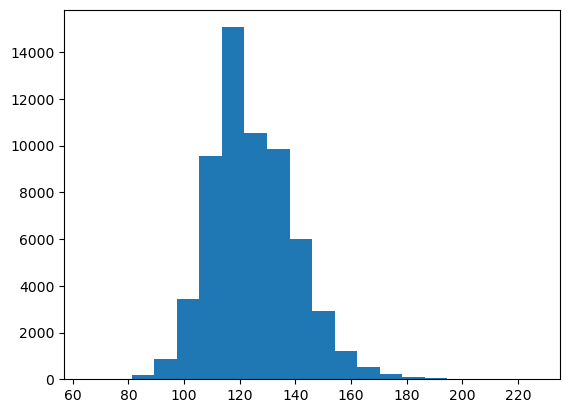

In [ ]:
# check the sbp_feedback range in the df when prescribinng ACE, 
df_ace = df[df['ACE']==1]
print('df_ace.shape =', df_ace.shape)
print(min(df_ace['sbp_feedback']))
print(max(df_ace['sbp_feedback']))

# plot the distribution of sbp_feedback
plt.hist(df_ace['sbp_feedback'], bins=20)
plt.show()

df_ace_only.shape = (87506, 75)
66.0
217.0


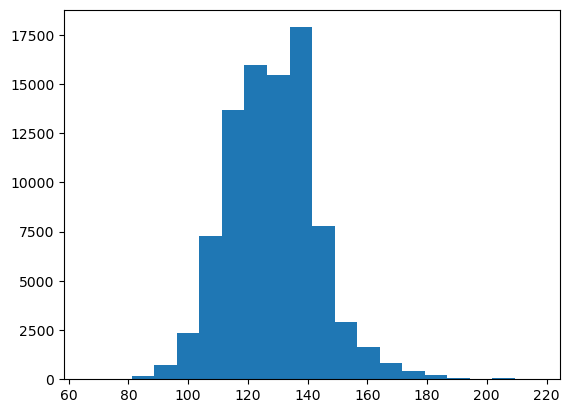

In [ ]:
# check the sbp_feedback range in the df when prescribing ACE
df_ace_only = df[df['action_code']=='0000']
print('df_ace_only.shape =', df_ace_only.shape)
print(min(df_ace_only['sbp_feedback']))
print(max(df_ace_only['sbp_feedback']))

# plot the distribution of sbp_feedback
plt.hist(df_ace_only['sbp_feedback'], bins=20)
plt.show()

In [ ]:
# loop through each possible combination of actions 00000 - 11111 (total 32 combinations), check the corresponding range of sbp_feedback, and plot the distribution
# for i in range(32):
#     action = str(bin(i))[2:].zfill(5)
#     print(i, 'action =', action)
#     df_action = df[df['action_code']==action]
#     print('df_action.shape =', df_action.shape)
#     print(min(df_action['sbp_feedback']))
#     print(max(df_action['sbp_feedback']))
#     plt.hist(df_action['sbp_feedback'], bins=20)
#     plt.show()

## Check correlation between state features

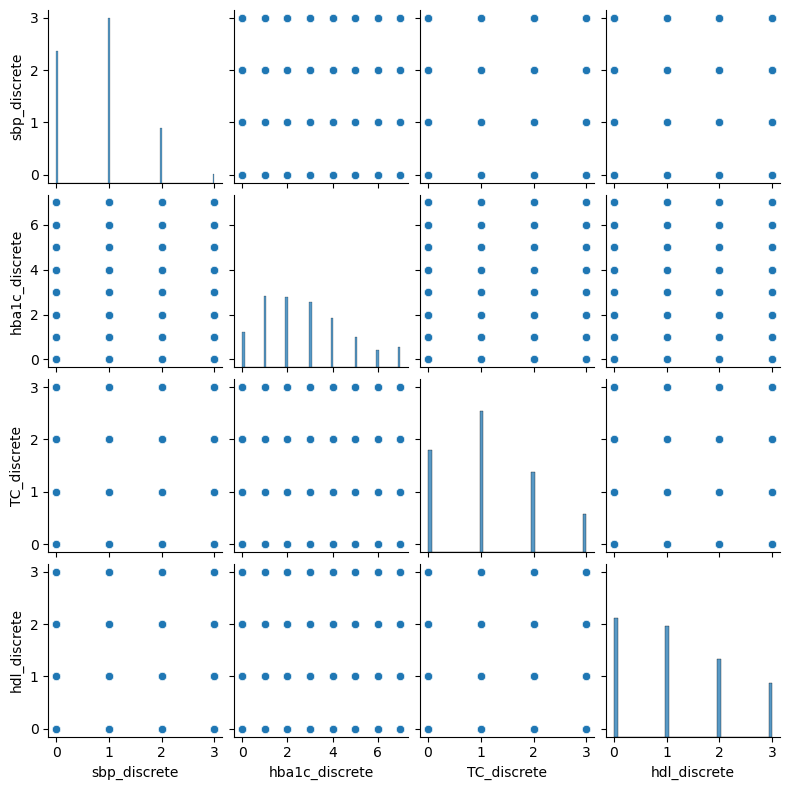

In [ ]:
sbp_discrete = df['sbp_discrete']
hba1c_discrete = df['hba1c_discrete']
TC_discrete = df['TC_discrete']
hdl_discrete = df['hdl_discrete']

# plot the correlation between every 2 features in state_features
import seaborn as sns
sns.pairplot(df[['sbp_discrete','hba1c_discrete','TC_discrete','hdl_discrete']], height=2)
plt.show()

No missing states.

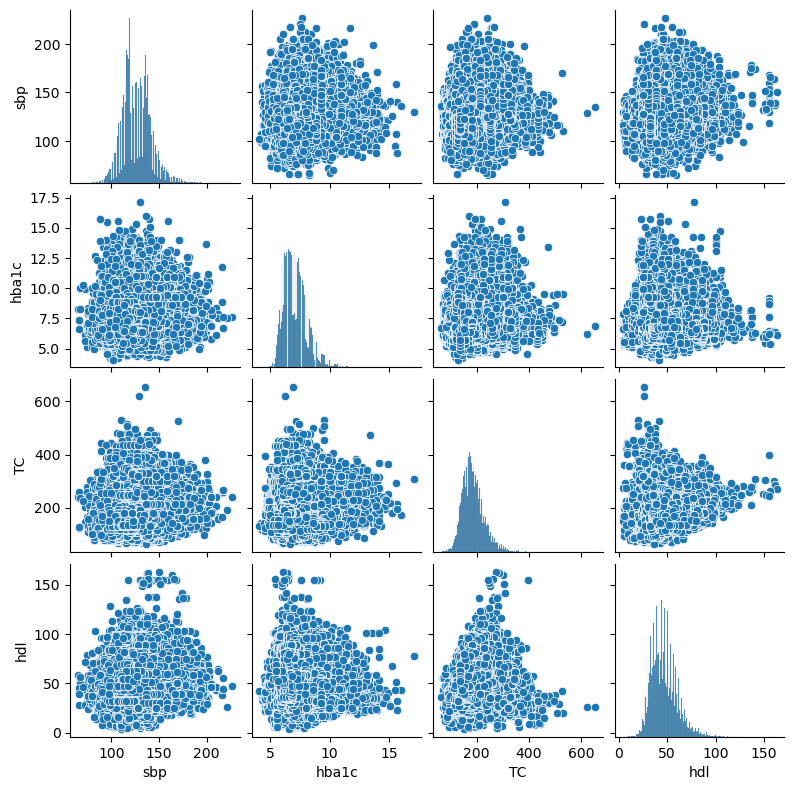

In [ ]:
import seaborn as sns
sns.pairplot(df[['sbp','hba1c','TC','hdl']], height=2, markers='o')
plt.show()

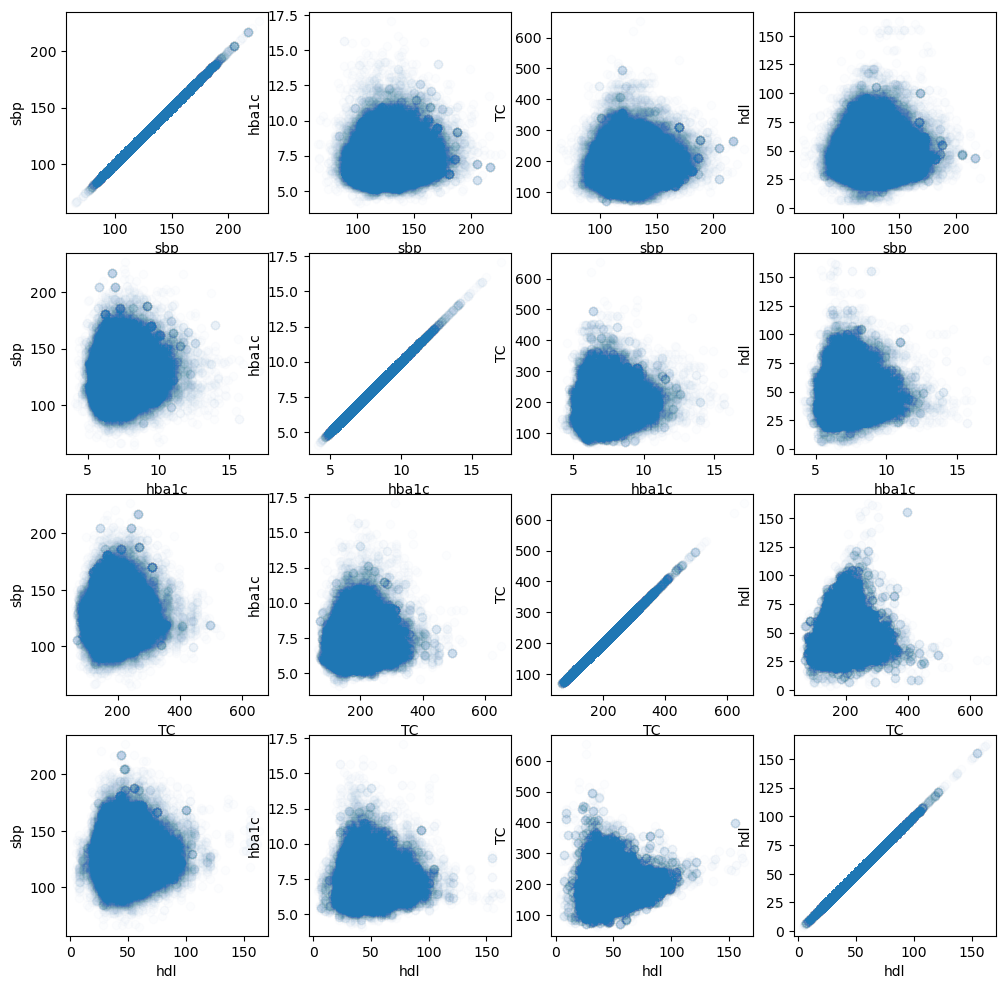

In [ ]:
# create a 4x4 subplots, for every 2 features in state_features, plot the scatter plot
state_fea = ['sbp','hba1c','TC','hdl']
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12,12))
for i in range(4):
    for j in range(4):
        # set the transparency to be 0.1
        axes[i,j].scatter(df[state_fea[i]], df[state_fea[j]], alpha=0.01)
        axes[i,j].set_xlabel(state_fea[i])
        axes[i,j].set_ylabel(state_fea[j])
plt.show()

In [ ]:
# check the correlation between every 2 features in state_features
df[['sbp_discrete','hba1c_discrete','TC_discrete','hdl_discrete']].corr()

,sbp_discrete,hba1c_discrete,TC_discrete,hdl_discrete
sbp_discrete,1.000000,0.092211,0.056054,0.024833
hba1c_discrete,0.092211,1.000000,0.086546,0.007174
TC_discrete,0.056054,0.086546,1.000000,0.067393
hdl_discrete,0.024833,0.007174,0.067393,1.000000


In [ ]:
df[['sbp','hba1c','TC','hdl']].corr()

,sbp,hba1c,TC,hdl
sbp,1.000000,0.090108,0.054551,0.029577
hba1c,0.090108,1.000000,0.090557,0.014992
TC,0.054551,0.090557,1.000000,0.078858
hdl,0.029577,0.014992,0.078858,1.000000


Plot the transition distribution

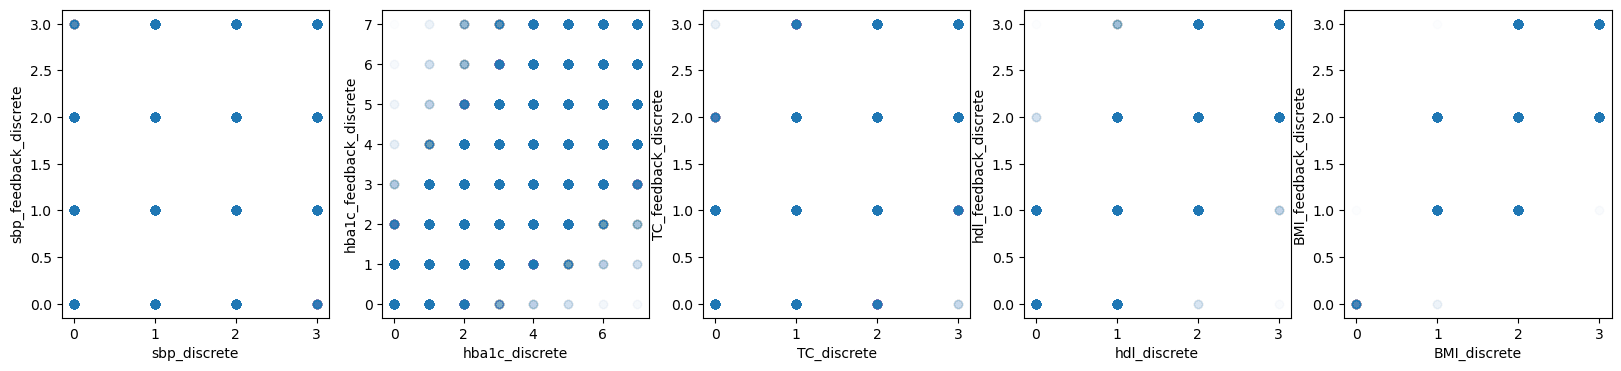

In [ ]:
# for each of the 5 features, plot the scatter plot between the feature and the its corresponding feedback
state_features_full = ['sbp_discrete','hba1c_discrete','TC_discrete','hdl_discrete','BMI_discrete']

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20,4))
for i in range(len(state_features_full)):
    x_name = state_features_full[i]
    y_name = x_name.split('_')[0] + '_feedback_discrete'
    axes[i].scatter(df[x_name], df[y_name], alpha=0.01)
    axes[i].set_xlabel(x_name)
    axes[i].set_ylabel(y_name)
    
plt.show()


Plot the 3D distribution point cloud

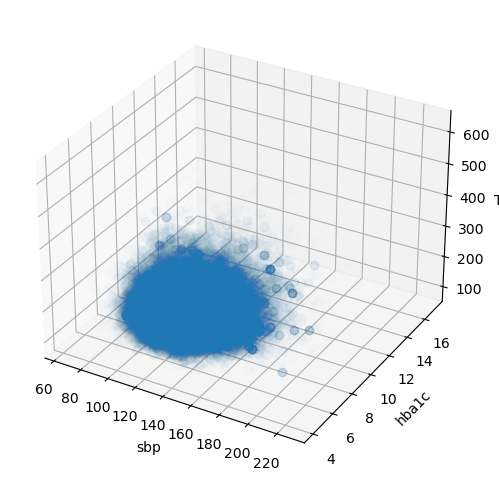

In [ ]:
# plot the 3D scatter plot between sbp, hba1c, and TC
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot( projection='3d')
# ax.scatter(df['sbp'], df['hba1c'], df['TC'], alpha=0.01)
ax.plot3D(df['sbp'], df['hba1c'], df['TC'], 'o', alpha=0.01)
ax.set_xlabel('sbp')
ax.set_ylabel('hba1c')
ax.set_zlabel('TC')
plt.show()


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176906 entries, 0 to 176905
Data columns (total 75 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   MaskID                   176906 non-null  int64  
 1   Visit                    176906 non-null  object 
 2   glycemia                 169239 non-null  float64
 3   bp                       114058 non-null  float64
 4   sbp                      176906 non-null  float64
 5   dbp                      176906 non-null  float64
 6   hr                       176906 non-null  float64
 7   hba1c                    176906 non-null  float64
 8   TC                       176906 non-null  float64
 9   trig                     176906 non-null  float64
 10  vldl                     176906 non-null  float64
 11  ldl                      176906 non-null  float64
 12  hdl                      176906 non-null  float64
 13  fpg                      176906 non-null  float64
 14  alt 